In [1]:
from b_field import structured_field
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import simps
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import MaxNLocator
from gammaALPs.nel.icm import NelICM
%matplotlib inline

In [21]:
def cart_to_sphere(x2, y2, z2):
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    theta2 = np.arccos(z2 / r2)
    phi2 = np.arctan2(y2, x2)
    return r2, theta2, phi2

def sphere_to_cart(r, theta, phi):
    x1 = r * np.sin(theta) * np.cos(phi)
    y1 = r * np.sin(theta) * np.sin(phi)
    z1 = r * np.cos(theta)
    return x1, y1, z1


alpha = 5.7634591968
c = 1
F_0 = c * (alpha * np.cos(alpha) - np.sin(alpha)) * alpha**2
norm_ = np.sqrt((3 * F_0 + alpha**5)**2) * 2 / (3 * alpha**2)

def trafo(r, theta, phi):
    '''Returns trafo used for vector fields, i.e. Field A cartesian = S * Field A spherical. S is returned'''
    mat = np.array([[np.sin(theta) * np.cos(phi), np.cos(theta) * np.cos(phi), -np.sin(phi)],
                    [np.sin(theta) * np.sin(phi), np.cos(theta) * np.sin(phi), np.cos(phi)],
                    [np.cos(theta), -np.sin(theta), 0]])
        #outdata[c, :, :] = mat[:, :]
    
    return mat


def rotation(n, x, angle):
    return n * np.inner(n, x) + np.cos(angle) * np.cross(np.cross(n, x), n) + np.sin(angle) * np.cross(n, x)

def cart_rotation(alpha, beta):
    rot_x = np.array([[1,             0,              0],
                      [0, np.cos(alpha), -np.sin(alpha)],
                      [0, np.sin(alpha),  np.cos(alpha)]])
    rot_y = np.array([[ np.cos(beta), 0, np.sin(beta)],
                      [            0, 1,            0],
                      [-np.sin(beta), 0, np.cos(beta)]])
    rot_z = np.array([[np.cos(beta), -np.sin(beta), 0],
                      [np.sin(beta),  np.cos(beta), 0],
                      [           0,             0, 1]])
    return rot_x, rot_z

def b_r(r, theta):
    
    zero_val = - np.cos(theta) * (6 * F_0 + 2 * alpha**5 * c) / (3 * alpha**2)
    if np.isclose(r, 0):
        val = zero_val
    else:
        val = 2 * np.cos(theta) * f(r) / r**2
    if r > 1:
        val = 0
    return b0 / norm_ * val
    

def b_theta(r, theta):
    zero_val = np.sin(theta) * (6 * F_0 + 2 * alpha**5 * c) / (3 * alpha**2)
    if np.isclose(r, 0):
        val = zero_val
    else:
        val = - np.sin(theta) * f_prime(r) / r
    if r > 1:
        val = 0
    return b0 / norm_ * val


def b_phi(r, theta):
    zero_val = 0
    if np.isclose(r, 0):
        val = zero_val
    else:
        val = alpha * np.sin(theta) * f(r) / r
    if r > 1:
        val = 0
    return b0 / norm_ * val


def f(r):
    return c * (alpha * np.cos(alpha * r) - np.sin(alpha * r) / r) \
           - F_0 * r**2 / alpha**2


def f_prime(r):
    return c * ( - alpha**2 * np.sin(alpha * r) \
                - alpha * np.cos(alpha * r) / r \
                + np.sin(alpha * r) / r**2) \
               - 2 * F_0 * r / alpha**2

def B_sphere(x1, x2, x3, sys='cart'):
    if sys == 'cart':
        r, theta, phi = cart_to_sphere(x1, x2, x3)
    elif sys=='sph':
        r, theta, phi = x1, x2, x3
    else:
        print('wrong coords')
    #print(r, theta, phi)
    return np.array([b_r(r / R, theta), b_theta(r / R, theta), b_phi(r / R, theta)])

def B_cart(x1, x2, x3, sys='cart'):
    if sys == 'cart':
        r, theta, phi = cart_to_sphere(x1, x2, x3)
    elif sys == 'sph':
        r, theta, phi = x1, x2, x3
    else:
        print('wrong coords')
    B_sph = B_sphere(r, theta, phi, sys='sph')
    #print(B_sph)
    t = trafo(r, theta, phi)
    #print(B_sph.shape)
    #print(t)
    B_c = np.matmul(trafo(r, theta, phi), B_sph.transpose()).transpose()
    return B_c
    

def rotation_measure(z, b_par, nel):
    return 812 * simps(b_par * nel, z)

def projection(field, direction):
    return np.inner(field, direction)

def axis_helper(x):
    l = x.shape[0]
    dx = x[1] - x[0]
    return np.linspace(x[0] - dx / 2, x[-1] + dx / 2, num=l + 1)


def B(x1, x2, x3, in_sys, out_sys):
    #get input coordinates
    if in_sys == 'cart':
        r, theta, phi = cart_to_sphere(x1, x2, x3)
    elif in_sys=='sph':
        r, theta, phi = x1, x2, x3
    else:
        print('wrong coords')
    
    #calculate bfield
    B = np.array([b_r(r / R, theta), b_theta(r / R, theta), b_phi(r / R, theta)])
    
    #get output coordinates
    if out_sys == 'sph':
        return B
    elif out_sys == 'cart':
        return np.matmul(trafo(r, theta, phi), B.transpose()).transpose()

#def kpc_to_arcmin()



In [26]:
rotation(np.array([1, 0, 0]), 1 / np.sqrt(2) * np.array([1, 1, 0]), np.pi/2)

array([7.07106781e-01, 4.32978028e-17, 7.07106781e-01])

In [82]:
def make_rm(R=93, b0=8.3, theta=0, phi=0, num=10):
    #th in degrees
    nel = NelICM(n0 = 39., n2 = 4.05, r_abell = 500., r_core = 80., r_core2 = 280., beta = 1.2, beta2= 0.58, eta = 0.5)
    theta_rad = np.radians(theta)
    
    #init coordinate space
    x = np.linspace(-R, R, num=num)
    y = np.linspace(-R, R, num=num)    # 100 integration steps, I think
    z = np.linspace(0, R, num=num)
    
    #get meshgrid
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    rotx, rotz = cart_rotation(np.radians(theta), np.radians(phi))
    rotxz = np.matmul(rotx, rotz)    # first rotate around LOS, then tilt w.r.t. LOS.
    # should be wrong like this! needs rotation around the tilted normal/LOS vector!
    XR = np.zeros(X.shape).flatten()
    YR = np.zeros(Y.shape).flatten()
    ZR = np.zeros(Z.shape).flatten()
    
    # rotate integration direction, i.e. e_y
    e_z = np.array([0, 0, 1])
    r_e_z = np.matmul(rotx, e_z.transpose()).transpose()

    # rotate coordinate grid
    for c_, (x_, y_, z_) in enumerate(zip(X.flatten(), Y.flatten(), Z.flatten())):
        rot = np.matmul(rotxz, np.array([x_, y_, z_]).transpose()).transpose()
        XR[c_] = rot[0]
        YR[c_] = rot[1]
        ZR[c_] = rot[2]

    
    XR = XR.reshape(X.shape)
    YR = YR.reshape(Y.shape)
    ZR = ZR.reshape(Z.shape)
    B_C = np.zeros((x.shape[0] * y.shape[0] * z.shape[0], 3))
    for c_, (x_, y_, z_) in enumerate(zip(XR.flatten(), YR.flatten(), ZR.flatten())):
        r_, theta_, phi_ = cart_to_sphere(x_, y_, z_)
        g = B_cart(r_, theta_, phi_, sys='sph')
        B_C[c_] = g
    R_mesh, _, _ = cart_to_sphere(XR, YR, ZR)
    NEL = nel(R_mesh)*1e-3
    B_C = B_C.reshape((x.shape[0], y.shape[0], z.shape[0], 3))
    #print(r_e_y)
    #print(B_C.shape)
    B_proj = np.inner(B_C, r_e_z)
    rm = np.zeros((x.shape[0], z.shape[0]))
    #print(NEL)
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            rm[i, j] = rotation_measure(z, B_proj[i, j, :], NEL[i, j, :])
    return x, y, z, rm

<IPython.core.display.Javascript object>


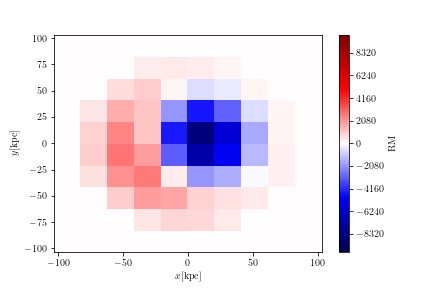

Text(0, 0.5, '$y [\\SI{}{\\kilo\\parsec}]$')

In [105]:
R = 93
b0 = 8.3
x, y, z, rm = make_rm(theta=45, phi=90, num=10)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
cmap = plt.get_cmap('seismic')
x_h = axis_helper(x)
y_h = axis_helper(y)
levels = MaxNLocator(nbins=cmap.N).tick_values(-1e4, 1e4)
norm = BoundaryNorm(levels, cmap.N)
pcol = ax.pcolor(x_h, y_h, rm, cmap=cmap, norm=norm, alpha=1)
cbar = cb = fig.colorbar(pcol, ax=ax, extend='neither', label='RM')
ax.set_xlabel('$x [\SI{}{\kilo\parsec}]$')
ax.set_ylabel('$y [\SI{}{\kilo\parsec}]$')

In [106]:
fig.savefig('rm_theta_45_90.png')

## Missing

Method to rotate rm map.

<IPython.core.display.Javascript object>


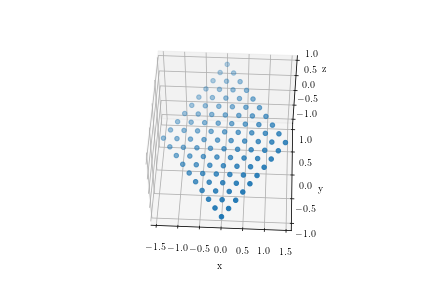

Text(0.5, 0, 'z')

In [81]:
def cart_rotation(alpha, beta):
    rot_x = np.array([[1,             0,              0],
                      [0, np.cos(alpha), -np.sin(alpha)],
                      [0, np.sin(alpha),  np.cos(alpha)]])
    rot_y = np.array([[ np.cos(beta), 0, np.sin(beta)],
                      [            0, 1,            0],
                      [-np.sin(beta), 0, np.cos(beta)]])
    rot_z = np.array([[np.cos(beta), -np.sin(beta), 0],
                      [np.sin(beta),  np.cos(beta), 0],
                      [           0,             0, 1]])
    return rot_x, rot_z
%matplotlib notebook
x = np.linspace(-1, 1, num=10)
y = np.linspace(-1, 1, num=10)
z = np.zeros(1)
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
rotx, rotz = cart_rotation(np.pi/4, np.pi/4)
rotzx = np.matmul(rotx, rotz)
xxr, yyr, zzr = np.zeros((xx.flatten().shape)), np.zeros((xx.flatten().shape)), np.zeros((xx.flatten().shape))
for c_, (x_, y_, z_) in enumerate(zip(xx.flatten(), yy.flatten(), zz.flatten())):
    rot = np.matmul(rotzx, np.array([x_, y_, z_]).transpose()).transpose()
    xxr[c_] = rot[0]
    yyr[c_] = rot[1]
    zzr[c_] = rot[2]
    
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(xxr, yyr, zzr)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [66]:
xx

array([[[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[-0.77777778],
        [-0.77777778],
        [-0.77777778],
        [-0.77777778],
        [-0.77777778],
        [-0.77777778],
        [-0.77777778],
        [-0.77777778],
        [-0.77777778],
        [-0.77777778]],

       [[-0.55555556],
        [-0.55555556],
        [-0.55555556],
        [-0.55555556],
        [-0.55555556],
        [-0.55555556],
        [-0.55555556],
        [-0.55555556],
        [-0.55555556],
        [-0.55555556]],

       [[-0.33333333],
        [-0.33333333],
        [-0.33333333],
        [-0.33333333],
        [-0.33333333],
        [-0.33333333],
        [-0.33333333],
        [-0.33333333],
        [-0.33333333],
        [-0.33333333]],

       [[-0.11111111],
        [-0.11111111],
        [-0.11111111],
   

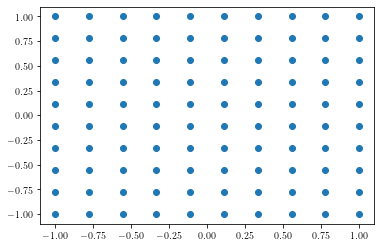

In [67]:
plt.scatter(xx, yy)